-

In [ ]:
# Connect to your Google Drive here
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt


from transformers.utils import logging as hf_logging
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# We enable logging level to info and use default log handler and log formatting
hf_logging.set_verbosity_info()
hf_logging.enable_default_handler()
hf_logging.enable_explicit_format()
from sklearn.model_selection import train_test_split

D:\Users\22A933N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
main_df = pd.read_csv('/dataset/updated_processed.csv')
main_df.head()

,text,category
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      47837 non-null  object
 1   category  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


In [ ]:
main_df['category'].value_counts()

Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: category, dtype: int64

In [ ]:
#MAIN_SIZE = 7000
#main_df = main_df.sample(n=MAIN_SIZE)

main_df.shape

(47837, 2)

Drop NAN

In [ ]:
encoded_dict = {'Hardware ':0, 'HR Support':1, 'Access':2, 'Miscellaneous':3, 'Storage':4, 'Purchase':5, 'Internal Project':6, 'Administrative rights':7}

main_df['category'] = main_df['category'].map(encoded_dict)

In [ ]:
main_df = main_df.dropna(axis='rows')

In [ ]:
main_df.shape

(34220, 2)

In [ ]:
main_df['category'].value_counts()

1.0    10915
2.0     7125
3.0     7060
4.0     2777
5.0     2464
6.0     2119
7.0     1760
Name: category, dtype: int64

In [ ]:
x = main_df['text']
y = main_df['category']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

Keras

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

[INFO|tokenization_utils_base.py:1802] 2023-02-21 23:56:06,028 >> loading file vocab.txt from cache at D:\Users\22A933N/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\vocab.txt
[INFO|tokenization_utils_base.py:1802] 2023-02-21 23:56:06,032 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:1802] 2023-02-21 23:56:06,035 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:1802] 2023-02-21 23:56:06,036 >> loading file tokenizer_config.json from cache at D:\Users\22A933N/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\tokenizer_config.json
[INFO|configuration_utils.py:660] 2023-02-21 23:56:08,714 >> loading configuration file config.json from cache at D:\Users\22A933N/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
[INFO|configurati

In [ ]:
x_train = tokenizer(
    text = x_train.tolist(),
    add_special_tokens=True,
    max_length=200,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text = x_test.tolist(),
    add_special_tokens=True,
    max_length=200,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
max_len = 200

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids, attention_mask = input_mask)[0] 
out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
out = tf.keras.layers.GlobalMaxPool1D()(out)
out = Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)
y = Dense(8, activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)


for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']  

In [ ]:
import os

Output directory to store weights

In [ ]:
### Create an output directory
output_dir = 'D:/Users/22A933N/Downloads/weights'
if not os.path.exists(output_dir): 
    os.makedirs(output_dir) 

In [ ]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)



In [ ]:
optimizer = Adam(learning_rate=5e-05, 
    epsilon=1e-08,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=15, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/15


D:\Users\22A933N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1711/1711 [==============================] - 4722s 3s/step - loss: 1.1534 - balanced_accuracy: 0.5874 - val_loss: 0.7608 - val_balanced_accuracy: 0.7396
Epoch 2/15
1711/1711 [==============================] - 4653s 3s/step - loss: 0.7419 - balanced_accuracy: 0.7471 - val_loss: 0.6100 - val_balanced_accuracy: 0.7878
Epoch 3/15
1711/1711 [==============================] - 4669s 3s/step - loss: 0.6318 - balanced_accuracy: 0.7870 - val_loss: 0.5675 - val_balanced_accuracy: 0.8073
Epoch 4/15
1711/1711 [==============================] - 4679s 3s/step - loss: 0.5696 - balanced_accuracy: 0.8069 - val_loss: 0.5351 - val_balanced_accuracy: 0.8149
Epoch 5/15
1711/1711 [==============================] - 4648s 3s/step - loss: 0.5354 - balanced_accuracy: 0.8181 - val_loss: 0.5030 - val_balanced_accuracy: 0.8270
Epoch 6/15
1711/1711 [==============================] - 4630s 3s/step - loss: 0.4977 - balanced_accuracy: 0.8336 - val_loss: 0.5100 - val_balanced_accuracy: 0.8255
Epoch 7/15
1711/1711 [=====

In [ ]:
import matplotlib.pyplot as plt

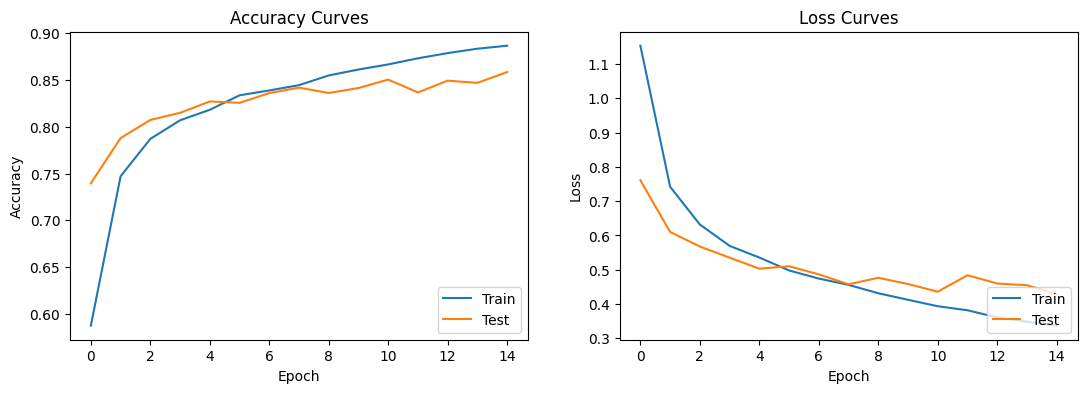

In [ ]:
h = train_history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['balanced_accuracy'])
plt.plot(h['val_balanced_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')


plt.subplot(122)
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

214/214 [==============================] - 747s 3s/step


array([2.1253607e-08, 5.3364658e-03, 1.5410372e-02, 9.1573894e-03,
       9.6094549e-01, 2.8896118e-03, 1.1086229e-03, 5.1520662e-03],
      dtype=float32)

In [ ]:
texts = input(str('Input text: '))
x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=200,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key, value)
    

1/1 [==============================] - 0s 135ms/step
Hardware  2.694793e-05
HR Support 17.867077
Access 45.895145
Miscellaneous 3.381594
Storage 5.3554406
Purchase 1.3869264
Internal Project 0.9927902
Administrative rights 25.121004


Confusion matrix

In [ ]:
predicted_raw_classes = np.argmax(predicted_raw, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_true_classes, predicted_raw_classes)

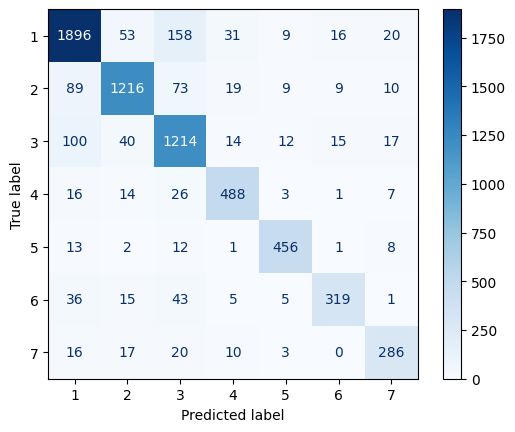

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_classes, predicted_raw_classes), display_labels=np.unique(predicted_raw_classes))
disp.plot(cmap='Blues') 
plt.grid(False)